In [40]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from ydata_profiling import ProfileReport
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# load the data
df = pd.read_csv('Electric_cars_dataset.csv')
df.head()

ID  VIN (1-10)     County        City State  ZIP Code  Model Year  \
0  EV33174  5YJ3E1EC6L  Snohomish    LYNNWOOD    WA   98037.0      2020.0   
1  EV40247  JN1AZ0CP8B     Skagit  BELLINGHAM    WA   98229.0      2011.0   
2  EV12248  WBY1Z2C56F     Pierce      TACOMA    WA   98422.0      2015.0   
3  EV55713  1G1RD6E44D       King     REDMOND    WA   98053.0      2013.0   
4  EV28799  1G1FY6S05K     Pierce    PUYALLUP    WA   98375.0      2019.0   

        Make    Model                   Electric Vehicle Type  \
0      TESLA  MODEL 3          Battery Electric Vehicle (BEV)   
1     NISSAN     LEAF          Battery Electric Vehicle (BEV)   
2        BMW       I3          Battery Electric Vehicle (BEV)   
3  CHEVROLET     VOLT  Plug-in Hybrid Electric Vehicle (PHEV)   
4  CHEVROLET  BOLT EV          Battery Electric Vehicle (BEV)   

  Clean Alternative Fuel Vehicle (CAFV) Eligibility  Electric Range  \
0           Clean Alternative Fuel Vehicle Eligible             308   
1           Clean Alternative Fuel Vehicle Eligible              73   
2           Clean Alternative Fuel Vehicle Eligible              81   
3           Clean Alternative Fuel Vehicle Eligible              38   
4           Clean Alternative Fuel Vehicle Eligible             238   

   Base MSRP  Legislative District  DOL Vehicle ID  \
0          0                  32.0       109821694   
1          0                  40.0       137375528   
2          0                  27.0       150627382   
3          0                  45.0       258766301   
4          0                  25.0       296998138   

                Vehicle Location  \
0   POINT (-122.287614 47.83874)   
1  POINT (-122.414936 48.709388)   
2  POINT (-122.396286 47.293138)   
3  POINT (-122.024951 47.670286)   
4  POINT (-122.321062 47.103797)   

                                    Electric Utility Expected Price ($1k)  
0                             PUGET SOUND ENERGY INC                   50  
1                             PUGET SOUND ENERGY INC                   15  
2  BONNEVILLE POWER ADMINISTRATION||CITY OF TACOM...                   18  
3      PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA)                 33.9  
4  BONNEVILLE POWER ADMINISTRATION||CITY OF TACOM...                41.78

In [3]:
# general information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64353 entries, 0 to 64352
Data columns (total 18 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   ID                                                 64353 non-null  object 
 1   VIN (1-10)                                         64353 non-null  object 
 2   County                                             64349 non-null  object 
 3   City                                               64344 non-null  object 
 4   State                                              64342 non-null  object 
 5   ZIP Code                                           64347 non-null  float64
 6   Model Year                                         64346 non-null  float64
 7   Make                                               64349 non-null  object 
 8   Model                                              64340 non-null  object 
 9   Electr

In [4]:
# summary statistics
df.describe()

ZIP Code    Model Year  Electric Range      Base MSRP  \
count  64347.000000  64346.000000    64353.000000   64353.000000   
mean   98143.452888   2018.186212      106.948985    2524.990754   
std     2856.064329      2.726742      104.093919   12402.895104   
min      745.000000   1993.000000        0.000000       0.000000   
25%    98052.000000   2017.000000       14.000000       0.000000   
50%    98121.000000   2018.000000       73.000000       0.000000   
75%    98370.000000   2021.000000      215.000000       0.000000   
max    99701.000000   2022.000000      337.000000  845000.000000   

       Legislative District  DOL Vehicle ID  
count          64184.000000    6.435300e+04  
mean              29.951904    1.972905e+08  
std               14.661124    1.069466e+08  
min                0.000000    4.385000e+03  
25%               19.000000    1.372865e+08  
50%               34.000000    1.753776e+08  
75%               43.000000    2.299039e+08  
max               49.000000    4.789346e+08

In [5]:
# generate profile report
profile = ProfileReport(df, title = 'Electric Cars Dataset Profile Report')
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
df.isnull().sum()

ID                                                     0
VIN (1-10)                                             0
County                                                 4
City                                                   9
State                                                 11
ZIP Code                                               6
Model Year                                             7
Make                                                   4
Model                                                 13
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric Range                                         0
Base MSRP                                              0
Legislative District                                 169
DOL Vehicle ID                                         0
Vehicle Location                                     510
Electric Utility                                     722
Expected Price ($1k)           

## Handle Missing Data

In [7]:
# Make a copy of the original dataframe
df_clean = df.copy()

In [8]:
# 1. drop identifier columns that don't add predictive value
# to reduce noise and prevent overfitting
df_clean.drop(['ID', 'VIN (1-10)', 'DOL Vehicle ID'], axis=1, inplace=True)

In [9]:
# 2. handle location features
# impute county, city, and zip code with mode
for col in ['County', 'City', 'ZIP Code']:
    mode = df_clean[col].mode()[0]
    df_clean[col].fillna(mode, inplace=True)

# fill state missing values with 'WA'
df_clean['State'].fillna('WA', inplace=True)

C:\Users\Hp\AppData\Local\Temp\ipykernel_8860\1154906504.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(mode, inplace=True)
C:\Users\Hp\AppData\Local\Temp\ipykernel_8860\1154906504.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing

In [10]:
# 3. Vehicle
# impute model year with median
df_clean['Model Year'].fillna(df_clean['Model Year'].median(), inplace=True)

#impute make and model with mode
for col in['Make', 'Model']:
    mode = df_clean[col].mode()[0]
    df_clean[col].fillna(mode, inplace=True)

C:\Users\Hp\AppData\Local\Temp\ipykernel_8860\912444627.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Model Year'].fillna(df_clean['Model Year'].median(), inplace=True)
C:\Users\Hp\AppData\Local\Temp\ipykernel_8860\912444627.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

In [11]:
# 6. Legislative District
# impute missing with mode
if 'Legislative District' in df_clean.columns:
    mode_val = df_clean['Legislative District'].mode()[0]
    df_clean['Legislative District'].fillna(mode_val, inplace=True)

C:\Users\Hp\AppData\Local\Temp\ipykernel_8860\3120928174.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Legislative District'].fillna(mode_val, inplace=True)


In [12]:
df_clean.isnull().sum()

County                                                 0
City                                                   0
State                                                  0
ZIP Code                                               0
Model Year                                             0
Make                                                   0
Model                                                  0
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric Range                                         0
Base MSRP                                              0
Legislative District                                   0
Vehicle Location                                     510
Electric Utility                                     722
Expected Price ($1k)                                   0
dtype: int64

In [13]:
df_clean.duplicated().sum()

np.int64(36112)

In [14]:
df_clean.drop_duplicates(inplace=True)


Encode Categorical Columns

In [15]:
# list of categorical columns
categorical_cols = [
    'County', 'City', 'State', 
    'Make', 'Model', 
    'Electric Vehicle Type', 
    'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 
    'Electric Utility'
]

# One-hot encode these columns (drop the first category to avoid collinearity)
df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

# convert the target 'Expected Price ($1k)' to numeric
df_encoded['Expected Price ($1k)'] = pd.to_numeric(df_encoded['Expected Price ($1k)'], errors='coerce')

## Handle Outliers


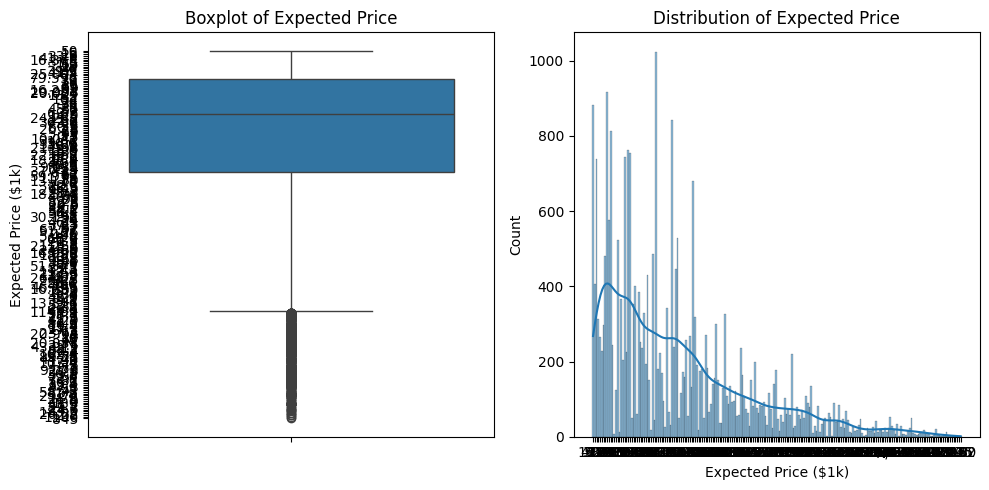

Price Statistics:
count     28241
unique      210
top          20
freq       1024
Name: Expected Price ($1k), dtype: object


In [16]:
# identify outliers
plt.figure(figsize=(10, 5))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(y=df_clean['Expected Price ($1k)'])
plt.title('Boxplot of Expected Price')

# Distribution plot
plt.subplot(1, 2, 2)
sns.histplot(df_clean['Expected Price ($1k)'], kde=True)
plt.title('Distribution of Expected Price')

plt.tight_layout()
plt.show()

# Statistical summary
print("Price Statistics:")
print(df_clean['Expected Price ($1k)'].describe())

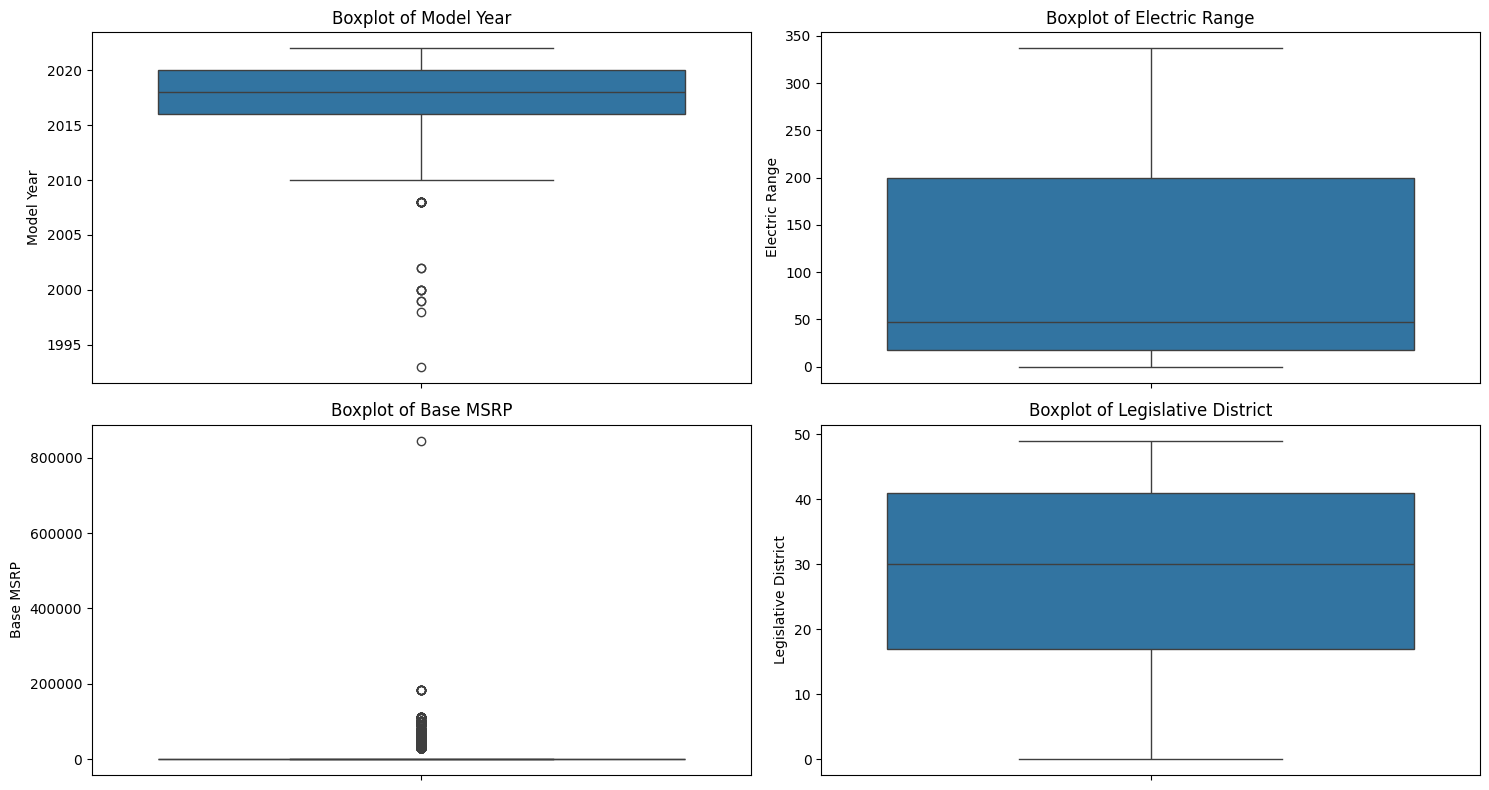

In [17]:
num_features = ['Model Year', 'Electric Range', 'Base MSRP', 'Legislative District']
plt.figure(figsize=(15, 8))
for i, col in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df_clean[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

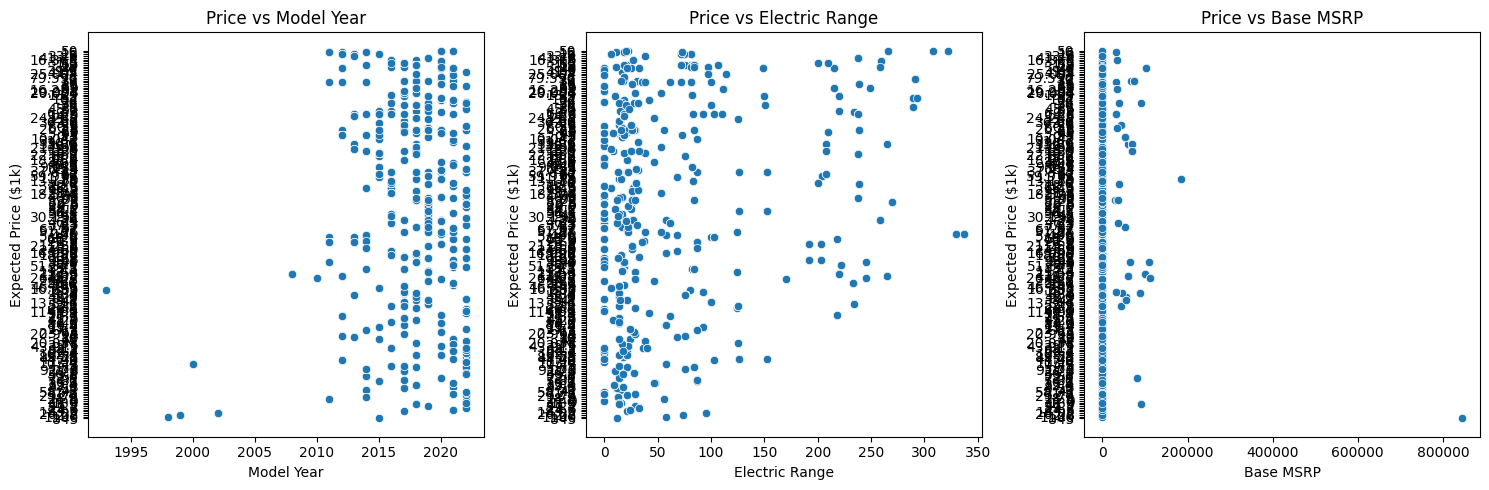

In [18]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(['Model Year', 'Electric Range', 'Base MSRP'], 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=df_clean[col], y=df_clean['Expected Price ($1k)'])
    plt.title(f'Price vs {col}')
plt.tight_layout()
plt.show()

In [19]:
# Select numerical columns
numerical_cols = df_clean.select_dtypes(include=['number'])

# Compute Q1, Q3, and IQR
Q1 = numerical_cols.quantile(0.25)
Q3 = numerical_cols.quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = (numerical_cols < lower_bound) | (numerical_cols > upper_bound)

# Count outliers in each column
outlier_counts = outliers.sum()

# Display outlier counts
print(outlier_counts)


ZIP Code                1868
Model Year                24
Electric Range             0
Base MSRP               2031
Legislative District       0
dtype: int64


In [20]:
df_clean['ZIP Code'] = df_clean['ZIP Code'].astype(str)  # Treat as string

In [21]:
df_clean['Is_Used'] = (df_clean['Base MSRP'] == 0).astype(int)

In [22]:
print("Base MSRP after capping:")
print(df_clean['Base MSRP'].describe())

print("\nIs_Used counts:")
print(df_clean['Is_Used'].value_counts())

Base MSRP after capping:
count     28241.000000
mean       3665.238129
std       14959.111670
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      845000.000000
Name: Base MSRP, dtype: float64

Is_Used counts:
Is_Used
1    26210
0     2031
Name: count, dtype: int64


In [23]:
numerical_cols = df_clean.select_dtypes(include=['number']).drop('ZIP Code', axis=1, errors='ignore')
Q1, Q3 = numerical_cols.quantile(0.25), numerical_cols.quantile(0.75)
outliers = ((numerical_cols < (Q1 - 1.5 * (Q3 - Q1))) | (numerical_cols > (Q3 + 1.5 * (Q3 - Q1)))).sum()
print(outliers)

Model Year                24
Electric Range             0
Base MSRP               2031
Legislative District       0
Is_Used                 2031
dtype: int64


In [24]:
# Step 1: Separate new vs. used vehicles
df_clean['Is_Used'] = (df_clean['Base MSRP'] == 0).astype(int)

# Step 2: For NEW vehicles only (MSRP > 0), cap at 99.5th percentile
new_vehicles = df_clean[df_clean['Base MSRP'] > 0]
cap_value = new_vehicles['Base MSRP'].quantile(0.995)
df_clean.loc[(df_clean['Base MSRP'] > cap_value) & (df_clean['Base MSRP'] > 0), 'Base MSRP'] = cap_value

# Step 3: Create logarithmic feature (handles extreme values better)
df_clean['Log_MSRP'] = np.log1p(df_clean['Base MSRP'])

Improved Base MSRP Distribution:
count     28241.000000
mean       3618.439149
std       13896.840612
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      110950.000000
Name: Base MSRP, dtype: float64


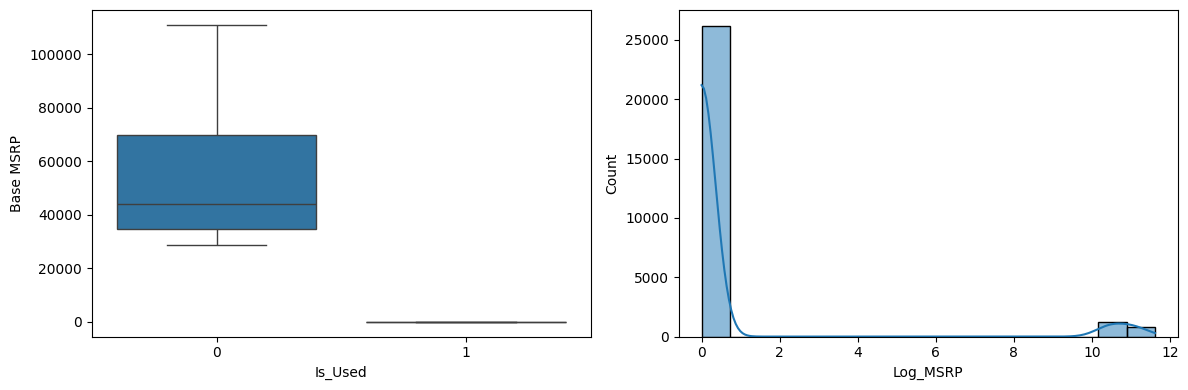

In [25]:
print("Improved Base MSRP Distribution:")
print(df_clean['Base MSRP'].describe())

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x='Is_Used', y='Base MSRP', data=df_clean)
plt.subplot(1, 2, 2)
sns.histplot(df_clean['Log_MSRP'], kde=True)
plt.tight_layout()
plt.show()

In [26]:
# split data
X = df_encoded.drop('Expected Price ($1k)', axis=1)
y = df_encoded['Expected Price ($1k)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
non_numeric_cols = X_train.select_dtypes(include=['object', 'category']).columns
print("Non-numeric columns:", non_numeric_cols)

Non-numeric columns: Index(['Vehicle Location'], dtype='object')


In [28]:
if 'Vehicle Location' in X_train.columns:
    # Extract latitude and longitude
    coords = X_train['Vehicle Location'].str.extract(r'POINT \(([^ ]+) ([^ ]+)\)')
    X_train['Longitude'] = coords[0].astype(float)
    X_train['Latitude'] = coords[1].astype(float)
    X_train.drop('Vehicle Location', axis=1, inplace=True)
    
    # Repeat for test set
    coords = X_test['Vehicle Location'].str.extract(r'POINT \(([^ ]+) ([^ ]+)\)')
    X_test['Longitude'] = coords[0].astype(float)
    X_test['Latitude'] = coords[1].astype(float)
    X_test.drop('Vehicle Location', axis=1, inplace=True)

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
# Drop rows where target is NaN
valid_idx = y_train.notna()
X_train = X_train[valid_idx]
y_train = y_train[valid_idx]

In [31]:
# Fill numeric columns with their median (more robust than mean)
for col in X_train.select_dtypes(include=['float64', 'int64']):
    col_median = X_train[col].median()
    X_train[col].fillna(col_median, inplace=True)
    X_test[col].fillna(col_median, inplace=True)  # Use same median from training set

# For categorical columns (if any), fill with mode
for col in X_train.select_dtypes(include=['object', 'category']):
    mode_val = X_train[col].mode()[0]
    X_train[col].fillna(mode_val, inplace=True)
    X_test[col].fillna(mode_val, inplace=True)

C:\Users\Hp\AppData\Local\Temp\ipykernel_8860\2115154651.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(col_median, inplace=True)
C:\Users\Hp\AppData\Local\Temp\ipykernel_8860\2115154651.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when 

In [32]:
print("Remaining NaN in X_train:", X_train.isnull().sum().sum())
print("Remaining NaN in X_test:", X_test.isnull().sum().sum())
print("Remaining NaN in y_train:", y_train.isnull().sum())

Remaining NaN in X_train: 0
Remaining NaN in X_test: 0
Remaining NaN in y_train: 0


In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## train the model

In [34]:
print("Training set shape:", X_train_scaled.shape)
print("NaN in data:", np.isnan(X_train_scaled).sum())
print("Unique target values:", y_train.nunique())

Training set shape: (22582, 934)
NaN in data: 0
Unique target values: 208


In [37]:
# Option 1: Use squared epsilon loss (allows dual=False)
linear_model = LinearSVR(
    C=1,
    dual=False,          # Now allowed
    loss='squared_epsilon_insensitive',
    max_iter=500,
    tol=1e-3,
    random_state=42
)
linear_model.fit(X_train_scaled, y_train)


LinearSVR(C=1, dual=False, loss='squared_epsilon_insensitive', max_iter=500,
          random_state=42, tol=0.001)

In [38]:
# Predict on test set
y_pred = linear_model.predict(X_test_scaled)

In [42]:
# Drop NaN rows from both y_test and y_pred
valid_idx = y_test.notna() & ~np.isnan(y_pred)
y_test_clean = y_test[valid_idx]
y_pred_clean = y_pred[valid_idx]

# Verify
print("Remaining NaN in y_test:", y_test_clean.isna().sum())
print("Remaining NaN in y_pred:", np.isnan(y_pred_clean).sum())

Remaining NaN in y_test: 0
Remaining NaN in y_pred: 0


In [45]:
# Calculate metrics
if len(y_test_clean) > 0:  # Only proceed if we have valid data
    mae = mean_absolute_error(y_test_clean, y_pred_clean)
    mse = mean_squared_error(y_test_clean, y_pred_clean)
    r2 = r2_score(y_test_clean, y_pred_clean)

print(f"MAE: ${mae:.2f}k")
print(f"MSE: ${mse:.2f}k")
print(f"R²: {r2:.2f}")

MAE: $5.54k
MSE: $86.55k
R²: 0.85
